<a href="https://colab.research.google.com/github/retr0nade/Abdominal-Organ-Segmentation-Using-MONAI/blob/main/Working_Model_with_MONAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

▶️ Step 1: Installing MONAI...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 71.5 MB/s eta 0:00:00
✅ Installation complete.

▶️ Step 2: Importing libraries and setting up...
MONAI version: 1.5.

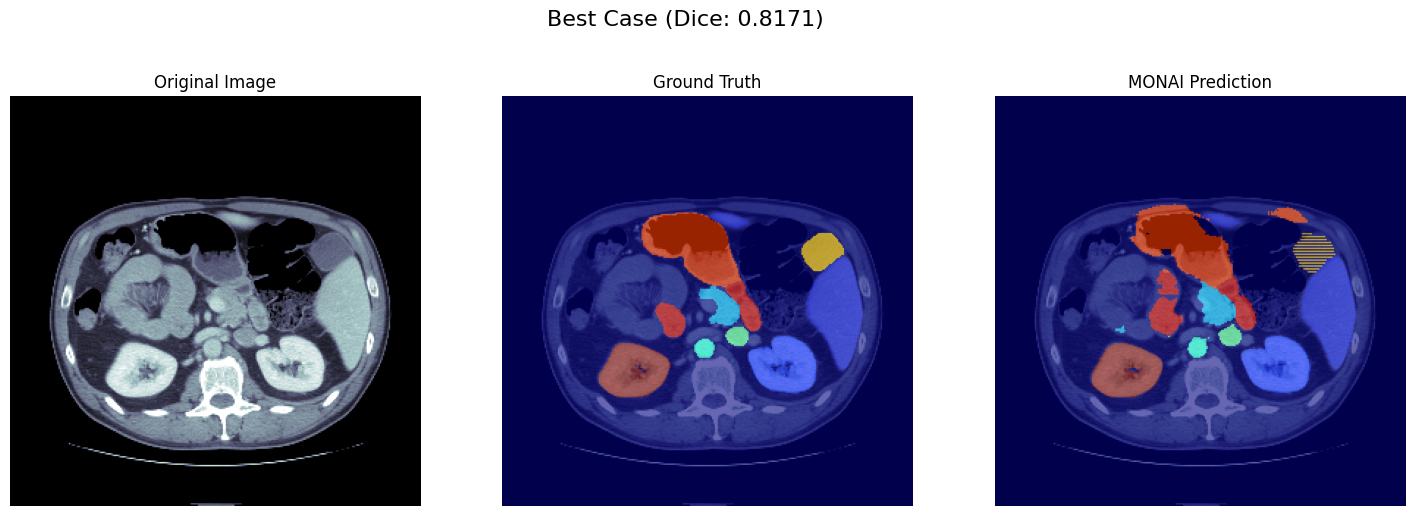

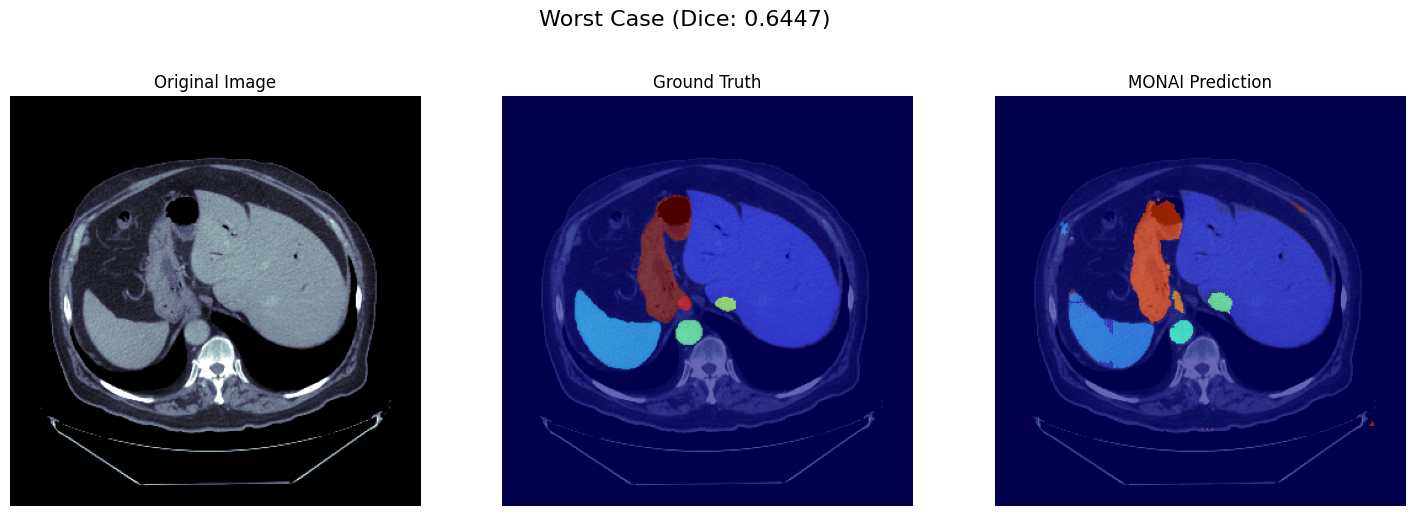


✅ Pipeline complete!


In [ ]:
# ==============================================================================
# 1. INSTALL MONAI AND SETUP
# ==============================================================================
print("▶️ Step 1: Installing MONAI...")
!pip install -q "monai[nibabel, tqdm]"
print("✅ Installation complete.")

print("\n▶️ Step 2: Importing libraries and setting up...")
import os
import shutil
import tempfile
import time
from glob import glob

import torch
import monai
import numpy as np
from monai.config import print_config
from monai.data import DataLoader, Dataset, decollate_batch
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandRotate90d,          # --- IMPROVEMENT: Added Augmentation ---
    RandGaussianNoised,     # --- IMPROVEMENT: Added Augmentation ---
    ScaleIntensityRanged,
    Spacingd,
    SpatialPadD,
    EnsureTyped,
)
from google.colab import drive
import matplotlib.pyplot as plt

print_config()
print("✅ Setup complete.")

# ==============================================================================
# 2. PREPARE DATASET
# ==============================================================================
print("\n▶️ Step 3: Preparing Data...")

try:
    drive.mount('/content/drive', force_remount=True)
    # Create a temporary directory to store the best model checkpoint
    temp_data_dir = tempfile.mkdtemp()

    drive_data_path = '/content/drive/MyDrive/FLARE22Train'
    images_path = os.path.join(drive_data_path, 'images')
    labels_path = os.path.join(drive_data_path, 'labels')

    train_images = sorted(glob(os.path.join(images_path, "*_0000.nii")))
    train_labels = sorted(glob(os.path.join(labels_path, "*.nii")))

    data_dicts = [{"image": img, "label": lbl} for img, lbl in zip(train_images, train_labels)]

    # Using an 80/20 split on the 50 available images
    train_files, val_files = data_dicts[:40], data_dicts[40:50]
    print(f"✅ Data prepared: {len(train_files)} training files, {len(val_files)} validation files.")

except Exception as e:
    print(f"❌ FATAL ERROR in Data Preparation: {e}")
    raise e

# ==============================================================================
# 3. DEFINE TRANSFORMS, DATASET, AND DATALOADER
# ==============================================================================
print("\n▶️ Step 4: Defining MONAI transforms and dataloaders...")

# Patch size for training
roi_size = (96, 96, 96)

# Define the full pipeline of preprocessing and augmentation for training
train_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    SpatialPadD(keys=["image", "label"], spatial_size=roi_size, method="end"),
    RandCropByPosNegLabeld(
        keys=["image", "label"],
        label_key="label",
        spatial_size=roi_size,
        pos=1,
        neg=1,
        num_samples=4,
        image_key="image",
        image_threshold=0,
    ),
    # --- IMPROVEMENT: Add more robust data augmentations ---
    RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),
    RandGaussianNoised(keys="image", prob=0.10, mean=0.0, std=0.1),
    EnsureTyped(keys=["image", "label"]),
])

# Define transforms for validation (no augmentations)
val_transforms = Compose([
    LoadImaged(keys=["image", "label"]),
    EnsureChannelFirstd(keys=["image", "label"]),
    Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
    EnsureTyped(keys=["image", "label"]),
])

# Create MONAI Datasets and DataLoaders
train_ds = Dataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=2)

val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=2)
print("✅ Dataloaders ready.")


# ==============================================================================
# 4. SET UP MODEL, LOSS, AND OPTIMIZER
# ==============================================================================
print("\n▶️ Step 5: Setting up Model, Loss, and Optimizer...")
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=14, # 13 organs + background
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
# We will compute the Dice score for each class separately during validation
dice_metric = DiceMetric(include_background=False, reduction="mean_batch")
print("✅ Model setup complete.")


# ==============================================================================
# 5. TRAINING LOOP
# ==============================================================================
print("\n▶️ Step 6: Starting Training...")
# --- IMPROVEMENT: Train for more epochs to allow for better convergence ---
max_epochs = 100
val_interval = 2 # Validate every 2 epochs
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([Activations(softmax=True), AsDiscrete(argmax=True, to_onehot=14)])
post_label = Compose([AsDiscrete(to_onehot=14)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (batch_data["image"].to(device), batch_data["label"].to(device))

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step*train_loader.batch_size}/{len(train_ds)}, train_loss: {loss.item():.4f}", end="\r")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device), val_data["label"].to(device))
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                dice_metric(y_pred=val_outputs, y=val_labels)

            # Aggregate the mean dice metric for all classes
            metric_batch = dice_metric.aggregate()
            metric = metric_batch.mean().item()
            dice_metric.reset()
            metric_values.append(metric)

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(temp_data_dir, "best_metric_model.pth"))
                print("saved new best metric model")

            print(f"current epoch: {epoch + 1} current mean dice: {metric:.4f}")
            print(f"best mean dice: {best_metric:.4f} at epoch: {best_metric_epoch}")

print(f"\n✅ Training complete. Best mean dice: {best_metric:.4f} at epoch {best_metric_epoch}")


# ==============================================================================
# 6. ENHANCED VISUALIZATION
# ==============================================================================
print("\n▶️ Step 7: Evaluating and Visualizing Results...")
model.load_state_dict(torch.load(os.path.join(temp_data_dir, "best_metric_model.pth")))
model.eval()

# --- IMPROVEMENT: Find best and worst validation cases for detailed visualization ---
validation_scores = {}
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        val_inputs = val_data["image"].to(device)
        val_labels = val_data["label"].to(device)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)

        # Calculate Dice score for this specific case
        val_outputs_post = [post_pred(i) for i in decollate_batch(val_outputs)]
        val_labels_post = [post_label(i) for i in decollate_batch(val_labels)]
        dice_metric(y_pred=val_outputs_post, y=val_labels_post)
        metric = dice_metric.aggregate().mean().item()
        dice_metric.reset()

        # Store the score with the file info
        case_name = os.path.basename(val_files[i]['image'])
        validation_scores[case_name] = metric

sorted_scores = sorted(validation_scores.items(), key=lambda item: item[1])
best_case_name, best_score = sorted_scores[-1]
worst_case_name, worst_score = sorted_scores[0]

print(f"\nBest performing case: {best_case_name} (Dice: {best_score:.4f})")
print(f"Worst performing case: {worst_case_name} (Dice: {worst_score:.4f})")

# Helper function for plotting
def plot_case(case_dict, title):
    with torch.no_grad():
        transformed_data = val_transforms(case_dict)
        val_input = transformed_data['image'].unsqueeze(0).to(device)
        val_output = sliding_window_inference(val_input, roi_size, 4, model)

        val_output_processed = torch.argmax(val_output, dim=1).detach().cpu().numpy()[0, :, :, :]
        ground_truth = transformed_data['label'][0, :, :, :].numpy()
        original_image = transformed_data['image'][0, :, :, :].numpy()

        slice_idx = np.argmax([ground_truth[:, :, z].sum() for z in range(ground_truth.shape[2])])

        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        fig.suptitle(title, fontsize=16)
        axes[0].imshow(np.rot90(original_image[:, :, slice_idx]), cmap="bone"); axes[0].set_title("Original Image"); axes[0].axis('off')
        axes[1].imshow(np.rot90(original_image[:, :, slice_idx]), cmap="bone"); axes[1].imshow(np.rot90(ground_truth[:, :, slice_idx]), cmap="jet", alpha=0.6); axes[1].set_title("Ground Truth"); axes[1].axis('off')
        axes[2].imshow(np.rot90(original_image[:, :, slice_idx]), cmap="bone"); axes[2].imshow(np.rot90(val_output_processed[:, :, slice_idx]), cmap="jet", alpha=0.6); axes[2].set_title("MONAI Prediction"); axes[2].axis('off')
        plt.show()

# Find the full dictionary for the best and worst cases
best_case_dict = next(item for item in val_files if best_case_name in item["image"])
worst_case_dict = next(item for item in val_files if worst_case_name in item["image"])

# Plot them
plot_case(best_case_dict, f"Best Case (Dice: {best_score:.4f})")
plot_case(worst_case_dict, f"Worst Case (Dice: {worst_score:.4f})")

# Clean up the temporary directory
shutil.rmtree(temp_data_dir)
print("\n✅ Pipeline complete!")